실험설계는 사실상 모든 응용 연구 분야에서 통계분석의 토대가 된다. 실험설계는 어떤 가설을 확인하거나 기각하기 위한 목표를 갖고 있다. 

이 장에서는 전통적인 실험설계에 대해 알아보고 데이터 과학에도 적용되는 몇몇 어려움에 대해 논의한다. 또한 통계적 추론에서 자주 인용되는 일부 개념들을 다루고 데이터 과학에서의 의미와 관련성(또는 무관련성)을 설명한다.

통계적 유의성, t 검정, p 값 등에 대한 자료를 찾아보면 전형적인 통게적 추론이라는 ***파이프 라인*** 속에 있음을 알 수 있다. 실험은 가설을 검정하기 위해 설계되고 원하는 최종적인 결론을 도출할 수 있도록 설계된다. 그리고 데이터를 수집하고 분석한 다음 마침내 결론을 도출한다. 

[전형적인 통계 추론 과정]

1. 가설을 세운다.
2. 실험을 설계한다.
3. 데이터를 수집한다.
4. 추론 및 결론을 도출한다.

In [46]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

# 3-1 A/B 검정

A/B 검정은 두 가지 처리 방법, 제품, 절차 중 어느 쪽이 다른 쪽보다 더 우월하다는 것을 입증하기 위해 실험군을 두 그룹으로 나누어 진행하는 실험이다. 종종 두 가지 처리 방법 중 하나는 기준이 되는 기존 방법이거나 아예 아무런 처리도 적용하지 않는 방법이 된다. 이를 ***대조군***이라고 한다. 

[용어 정리]
- 처리(Treatment): 어떤 대상에 주어지는 특별한 환경이나 조건(약, 가격, 인터넷 뉴스 제목)
- 처리군(Treatment Group): 특정 처리에 노출된 대상들의 집합
- 대조군/대조그룹(Control Group): 어떤 처리도 하지 않은 대상들의 집단
- 임의화/랜덤화(Randomization): 처리를 적용할 대상을 임의로 결정하는 과정
- 대상(Subject): 처리를 적용할 개체 대상(유의어: 피실험자)
- 검정통계량(test Statistics): 처리 효과를 측정하기 위한 지표

[A/B검정 예시]
- 종자 발아가 어디에서 더 잘 되는지 알아보기 위해 두 가지 토양 처리를 검정한다.
- 암을 더 효과적으로 억제하는 두 가지 치료법을 검정한다.
- 두 가지 가격을 검정하여 더 많은 순이익을 산출하는 쪽을 결정한다.
- 두 개의 인터넷 뉴스 제목을 검정하여 더 많은 클릭을 생성하는 쪽을 결정한다.
- 두 개의 인터넷 광고를 검정하여 어느 것이 더 높은 전환율을 얻을지 판단한다.

제대로 된 A/B 검정에는 둘 중 어느 한쪽의 처리를 할당할 수 있는 대상이 주어진다. 이상적으로 피험자는 무작위로 어느 처리에 할당한다. 그러면 처리군 간의 차이는 다음 두 가지 이유 중 하나 때문이라고 할 수 있다.
- 다른 처리의 효과
- 어떤 대상이 어떤 처리에 배정될지에 대한 경우의 수 (즉 무작위로 배정한 결과 자연스럽게 더 좋은 결과를 보이는 대상들이 A 또는 B 한쪽에 집중됨)

또한 그룹 A와 그룹 B를 비교하는데 사용하는 검정통계량 또는 측정 지표에 주의를 기울여야 한다.

측정 지표가 연속형 변수(구매액, 수익 등)인지 횟수를 나타내는 변수(입원 일수, 방문한 페이지 수)인지에 따라 결과가 다르게 표시될 수 있다. 

### 3-1-1 대조군은 왜 필요할까?
대조군이 없다면 ***모든 다른 것들은 동일하다***는 보장이 없으며 어떤 차이가 처리(또는 우연) 때문인지 확신할 수 없다. 대조군의 경우 관심 처리를 뺀 나머지는 처리군과 동일한 조건이 적용된다. 

##### NOTE: 연구를 위한 눈가림
***눈가림(맹검)연구***란 피험자가 처리 A나 처리 B중 어느것을 받고 있는지 알지 못하도록 하는 연구 방식이다. 

### 3-1-2 왜 하필 A/B일까? C,D가 아니라?

A/B 검정은 마케팅 및 전자 상거래 분야에서 널리 사용되지만 그렇다고 이것이 유일한 통계 실험 유형인 것은 아니다. 당연히 추가적인 처리가 포함될 수 있다. 피실험자를 대상으로 반복 측정을 할 수도 있다. 

전통적인 의미의 통계적 실험설계는 특정 처리 방법의 효과에 대한 정적인 질문에 답하는데 초점을 맞추었다. 데이터 과학자들은 이러한 질문에는 별로 관심이 없다.

1. 가격 A와 가격 B의 차이가 통계적으로 유의한가?\
***보다는***
2. 가능한 여러 가격 중에서 가장 좋은 가격은 얼마일까?

##### 주요 개념
- 연구 대상을 두 가지 이상의 그룹 중 하나에 할당한다. 여기서 서로 다른 처리 조건을 제외한 나머지 조건들은 정확히 동일하게 처리된다.
- 이상적으로, 대상들은 그룹에 무작위로 배정된다.

# 3-2 가설검정

가설검정(hypothesis test) 혹은 유의성검정(significance test)은 발표된 대부분의 연구 논문에 등장하는 전통적인 통계분석 방법이다. 목적은 관찰된 효과가 우연에 의한 것인지 여부를 알아내는 것이다.

##### 용어 정리
- 귀무가설(null hypothesis): 우연 때문이라는 가설(유의어: 영가설)
- 대립가설(alternative hypothesis):  귀무가설과의 대조(증명하고자 하는 가설)
- 일원검정(one-way test): 한 방향으로만 우연히 일어날 확률을 계산하는 가설검정
- 이원검정(two-way test): 양방향으로 우연히 일어날 확률을 계산하는 가설검정

### 3-2-1 귀무가설

가설검정은 다음과 같은 논리를 사용한다. ***인간은 실제로 우연히 발생한 일이라도 그것이 흔하지 않다면, 그것에 뭔가 의미가 있을 것이라고 해석하는 경향을 가지고 있다.그러므로 실험에서 얻은 그룹 간의 차이가 무작위로 얻을 수 있는 합리적인 수준과는 극단적으로 다르다는 증거가 필요하다*** 

그룹들이 보이는 결과는 서로 동일하며, 그룹 간의 차이는 우연에 의한 결과라는 것을 기본 가정으로 설정한며 이를 ***귀무가설***이라고 부른다.
- 결국 귀무가설이 틀렷다는 것을 입증해서 A 그룹과 B 그룹 간의 차이가 우연이 아니라는 것을 보여주는 것이 모두의 희망이다.

이를 위한 한가지 방법은 ***재표본추출 순열검정***을 통한 방법이 있다.
- A와 B 그룹의 결과를 서로 섞어서 비슷한 크기의 그룹들을 반복적으로 만든 다음 관찰된 차이를 각 경우에서 발생되는 차이와 비교했을 때 얼마나 극단적인지를 관찰하는 방법이다. 
- 그룹 A와 B를 섞어서 만든 결과들을 결합한 것과 이들로부터 재표본하는 절차는 그룹 A와 B가 동등하고 상효 교환이 가능하다는 귀무가설을 구현하는 것이다.

### 3-2-2 대립가설

가설검정은 그 성격상 귀무가설 뿐 아니라 그와 대립하는 가설을 포함한다. 
- 예시1:
    - 귀무가설: 그룹 A와 그룹 B의 평균에는 차이가 없다.
    - 대립가설: A와 B는 다르다(더 크거나 작을 수 있다.)
- 예시2:
    - 귀무가설: A <= B
    - 대립가설: A > B
- 예시3:
    - 귀무가설: B는 A보다 X% 더 크지 않다.
    - 대립가설: B는 A보다 X% 크다.
    
### 3-2-3 일원/이원 가설 검정
A/B 검정을 통해 기존에 기본으로 사용하던 옵션(A라고 하자)과 비교하여 새옵션(B라고 하자) 이 어떠한지 검증한다고 하자. 방향성을 고려한 단방향(directional) 대립가설이 필요하다(B가 A보다 낫다). 이 경우 일원(또는 한쪽 꼬리) 가설검정을 사용한다. 즉 우연에 의한 극단적인 결과에 대해 한 방향만을 고려하여 p값을 계산한다는 의미.

어느쪽으로도 속지 않도록 가설검정을 원한다면 대립가설은 양방향(bidirectional)이 된다. 이 경우 이원 가설을 사용한다. 우연에 의한 극단적인 결과가 양쪽에서 나타날 p값을 계산한다는 것을 의미한다.

##### 주요 개념
- 귀무가설: 관찬한 효과가 특별한 것이 아니고 우연에 의해 발생한 것이라는 개념을 구체화하는 일종의 논리적 구조
- 가설검정: 귀무가설이 사실이라고 가정하고, ***영모형_Null Model (확률 모형: Probability Model)***을 생성하여 관찰한 효과가 해당 모델로부터 합리적으로 나올 수 있는 결과인지를 검증하는 것

# 3-3 재표본 추출


통계학에서 재표본추출이란 랜덤한 변동성을 알아보자는 일반적인 목표를 가지고 관찰한 데이터의 값에서 표본을 반복적으로 추출하는 것을 의미한다. 또한 일부 머신러닝 모델의 정확성을 평가하고 향상시키는 데에도 적용할 수 있다.(예, 부트스트랩 데이터 집합을 기반으로 하는 의사결정 트리 모델에서 나온 예측모델로부터 배깅이라는 절차를 통해 평균 예측값을 구할 수있다.)

재표본추출에는 ***부트스트랩***과 ***순열검정***이라는 두가지 유형이 있다. 이전 장에서 다룬 것처럼 부트스트랩은 추정의 신뢰성을 평가하는데 사용된다. 

이번 절에서는 일반적으로 두 개 이상의 그룹과 관련된 가설을 검증하는데 사용되는 순열검정을 알아본다.

##### 용어 정리:
- 순열 검정(Permutation test): 
    - 두 개 이상의 표봉늘 함께 결합하여 관측값들을 무작위로 재표본으로 추출하는 과정을 의미한다. (유의어: 임의화검정, 임의순열검정, 정확검정)
    
- 재표본추출:
    - 관측 데이터로부터 반복해서 표본추출하는 과정
    
- 복원/비복원(with or without replacement):
    - 표본을 추출할 때, 이미 한 번 뽑은 데이터를 다음번 추출을 위해 다시 제자리에 돌려 놓거나/ 다음 추출에서 제외하는 표본추출 방법

### 3-3-1 순열검정

순열과정에는 두 개 이상의 표본이 관여되며 이들은 통상적으로 A/B 또는 기타 가설검정을 위해 사용되는 그룹들이다. ***순서를 바꾼다(permute)***라는 의미의 영어 표현은 말그대로 어떤 값들의 집합에서 값들의 순서를 변경한다는 의미이며 절차는 다음과 같다.

1. 여러 그룹의 결과를 단일 데이터 집합으로 결합한다.
2. 결합된 데이터를 잘 섞은 후, 그룹 A와 동일한 크기의 표본을 무작위로(비복원) 추출한다. 
3. 나머지 데이터에서 그룹 B와 동일한 크기의 샘플을 무작위로(비복원) 추출한다.
4. C, D 등의 그룹에 대해서도 동일한 작업을 수행한다. 이제 원본 표본의 크기를 반영하는 재표본을 수집했다.
5. 원래 샘플(예를 들면 그룹 비율의 차이)에 대해구한 통계량 또는 추정치가 무엇이었든 간에 지금 추출한 재표본에 대해 모두 다시 계산하고 기록한다. 이것으로 한 번의 순열 반복이 진행된다. 
6. 앞선 단게들을 R번 반복하여 검정 통계량의 순열분포를 얻는다.



### 3-3-2 예제: 점착성

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

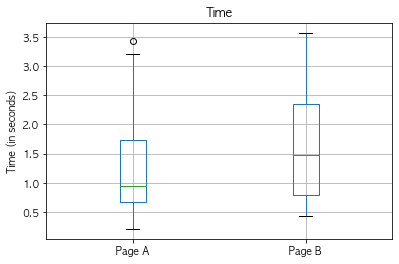

In [2]:
session_times = pd.read_csv('data_in/web_page_data.csv')
ax = session_times.boxplot(by='Page', column = 'Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

In [3]:
# 각 그룹의 평균
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a 

0.3566666666666669

페이지 B는 페이지 A와 비교하여 세션 시간이 평균 35.67초 정도 더 길다. 문제는 이 차이가 우연에 의한 것인지 아니면 통게적으로 중요한 것인지를 판단하는 일이다. 

이에 대한 한 가지 대답은 순열검정을 적용하는 것이다. 모든 세션 시간을 결합한 다음 잘 섞은 후 21개의 그룹(A 페이지의 경우 $n_{A} = 21$)과 15개의 그룹(B의 경우 $n_{B} = 15$)으로 반복하여 표본을 추출한다.

순열 검정을 적용하려면 36개의 세션 시간을 21개(페이지 A)와 15개(페이지 B)의 그룹에 랜덤하게 할당하는 기능이 필요하다.

In [4]:
### 순열검정을 파이썬으로 구현
def perm_fun(x, nA, nB):
    # 전체 샘플 수
    n = nA + nB
    # A와 B의 합 중 B 그룹의 개수만큼 샘플(인덱스로)
    idx_B = set(random.sample(range(n), nB))
    # 남은 것들에 대해 A에 할당(인덱스로)
    idx_A = set(range(n)) - idx_B
    # 두 차이를 리턴
    
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))


0.22295238095238123


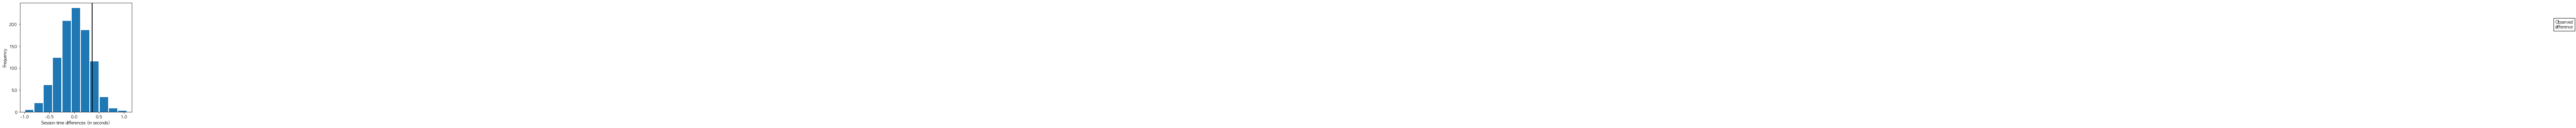

In [5]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color = 'black', lw=2)
ax.text(50,190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
plt.show()

무작위 순열로 구한 평균 세션 시간의 차이가 가끔 실제 관찰된 세션 시간의 차이(수직선)를 넘어가는 것을 볼 수 있다. 이 경우는 12.6%의 확률로 발생한다.

In [7]:
import numpy as np
np.mean(np.array(perm_diffs) > mean_b - mean_a)

0.116

### 3-3-3. 전체 및 부트스트랩 순열검증

아펏 살펴본 랜덤 셔플링, 절차를 ***임의순열검정(random permutation test)*** 또는 ***임의화검정(randomization test)***이라고 부르며 이 외에도 순열 검정에는 두가지 변종이 있다.
- 전체순열검정(exhaustive permutation test)
    - 데이터를 무작위로 섞고 나누는 대신 실제로 나눌 수 있는 모든 가능한 조합을 찾음
    - 샘플 크기가 작을 때만 실용적
    - 셔플링을 많이 할수록 임의순열검정 결과는 전체순열검정과 유사해짐
    - 영모형이 어떤 유의수준 이상으로 더 '유의해진다'가 아니라 좀 더 정확한 결론을 보장하는 통계적 속성 때문에 정확검정(exact test)라고도 함
    
- 부트스트랩 순열검정(bootstrap permutation test)
    - 무작위 순열검정의 2단계와 3단계에서 비복원으로 하던 것을 ***복원 추출***로 수행
    - 재표본추출 과정에서 모집단에서 개체를 선택할 때 임의성을 보장할 뿐만 아니라 개체가 처리군에 할당될 때에도 임의성을 보장



### 3-3-4 순열검정: 데이터 과학의 최종 결론

순열검정은 랜덤한 변이가 어떤 역할을 하는지 알아보기 위해 사용되는 휴리스틱한 절차다.
- 휴리스틱(heuristics): 불충분한 시간이나 정보로 인해 합리적인 판단을 할 수 없거나 체게적이면서 합리적인 판단이 굳이 필요하지 않은 상황에서 사람들이 빠르게 사용할 수 있게 보다 용이하게 구성된 간편추론의 방법

수학적 접근과 재표본추출의 장점은 추론에서 "모두에게 맞는" 접근방식이라고 말할 수 있다는 점이며 정규분포를 따라야 한다는 가정도 필요 없다

##### 주요 개념
- 순열검정에서는 여러 표본을 결합한 다음 잘 섞는다.
- 그런 다음 섞인 값들을 이용해 재표본추출 과정을 거쳐 관심있는 표본통계량을 계산한다
- 이 과정을 반복하고 재표본추출한 통계를 도표화
- 관측된 통계량을 재표본추출한 분포와 비교하면 샘플 간에 관찰된 차이가 우연인지 판단 가능

# 3-4 통계적 유의성과 p값

통계적 유의성:
- 통계학자가 자신의 실험 결과가 우연히 일어난 것인지 아닌지 판단하는 방법
- 결과가 우연히 벌어질 수 있는 변동성의 바깥쪽에 존재한다면 통계적으로 유의하다고 말한다.

##### 용어 정리
- p값(p-value): 모델이 주어졌을 때 관측된 결과처럼 극단적인 결과를 얻은 확률
- 알파(alpha): 실제 결과가 통계적으로 의미있는 것으로 간주되기 위해 능가해야하는 '비정상적인' 기능성의 임계확률
- 제1종 오류(type I error): 우연을를 실제라고 잘못 (F - T)
- 제2종 오류(type II error): 실제효과를 우연이라고 잘못(T - F)

##### 표 3-2 
|결과|가격 A|가격 B|
|:--:|:--:|:--:|
|전환|200|182|
|전환되지 않음|23,539|22,406|

재표본추출 절차를 사용하면 가격 A와 가격 B간의 전환 차이가 우연에 의한 것인지 검정할 수 있다. 여기서 우연에 의한 차이란 곧 두 전환율 사이에 차이가 없다는 귀무가설의 확률모형을 가지고 생성한 데이터의 랜덤 변이를 의미한다.

Observed Difference:  0.0368%


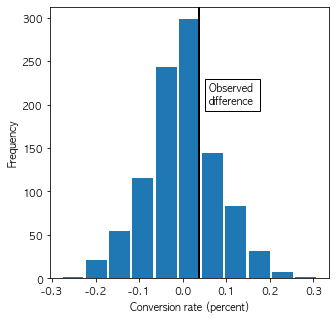

In [9]:
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed Difference: {obs_pct_diff: .4f}%')

conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)


perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
             for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed \ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')
plt.show()

1,000개의 재표본추출 결과를 보여주는 히스토그램이다. 이 경우 관측된 0.0368%의 차이는 랜덤 변이의 범위내에 있다.

### 3-4-1. p값

p 값과 같이 통계적 유의성을 정확히 측정하기 위한 지표가 필요하다. 이것은 확률모형이 관측된 결과보다 더 극단적인 겨롸글 랫ㅇ성하는 빈도라고 할 수 있다.

다시 말해 순열검정으로 얻은 결과 중 관찰된 차이와 같거나 더 큰 차이를 보이는 경우의 비율로 p값을 추정 가능. 파이썬에서 ***scipy.stats.chi2_contingency***

In [21]:
from scipy.stats import chi2_contingency
survivors = np.array([[200, 23739 -200], 
                     [182, 22588 - 182]])
chi2, p_value, df, _ = chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


### 3-4-2. 유의수준

어떤 결과가 우연히 발생한 것인지 아니면 '진짜 특별한' 것인지 결정하는 임곗값을 보통 유의수준(알파)이라고 한다. 이는 확률 문제가 '우연히 일어날 확률은 무엇인가?'가 아니라

$$ 랜덤 모델이 주어졌을 때, 극단적인 결과가 나올 확률은 정도인가?$$

##### p 값에 대한 논란
우리가 p값을 통해 전달하고자 하는 의미는 ***결과가 우연에서 비롯될 확률*** 그러나 실제 p값이 나타내는 것은 ***랜덤 모델이 주어졌을 때, 그 결과가 관찰된 결과보다 더 극단적일 확률*** 

이는 곧 p 값이 유의미하다고 해서 그것이 기대처럼 바로 '증거'가 되는 것은 아니다. p값의 진짜 의미를 이해하면 ***통계적으로 유의미하다***라는 결론에 대한 논리적 뒷받침이 다소 약하다는 것을 알게 된다.

미국통계협회의 성명서는 연구자들과 저널 편집자들에게 아래 6가지 원칙을 강조함
1. p 값은 이 데이터가 특정 통게 모델과 얼마나 상반되는지 나타낼 수 있다.
2. p 값은 연구 가설이 사실일 확률이나, 데이터가 랜덤하게 생성되었을 확률을 측정하는 것이 아니다.
3. 과학적 결론, 비즈니스나 정책 결정은 p 값이 특정 임곗값을 통과하는지 여부를 기준으로 해서는 안된다.
4. 적절한 추론을 위해서는 완전한 보고와 투명성이 요구된다.
5. p 값 또는 통계적 유의성은 효과의 크기나 결과의 중요성을 의미하지 않는다.
6. p 값 그자체는 모델이나 가설에 대한 증거를 측정하기 위한 좋은 지표는 아니다. 

##### 실제적인 유의미
결과가 통계적으로 유의미하고해서 실제적으로 유의미하다는 뜻은 아니다. 실질적으로 의미가 없는 작은 차이라도 표본이 충분히 클 경우 통계적으로 유의하다는 결과가 나올 수 있다. 표본이 클수록 작고 의미 없는 효과가 우연이라고 볼 수 없을만큼 충분히 크게 크게 보일 수 있다.

### 3-4-3 제1종과 제2종 오류

통계적 유의성을 평가할 때는 두 가지 유형의 오류가 발생할 수 있다.
- 1종 오류: 어떤 효과가 우연히 발생한 것인데, 그것이 사실이라고 잘못 판단하
- 2종 오류: 어떤 효과가 실제로 있는 것인데, 그것이 우연히 발생한 것이라고 잘못 판단

실제 2종 오류는 어떤 오류라기보다 표본크기가 너무 작아서 효과를 알아낼 수 없다고 판단하는 것과 같다. 표본 크기가 더 클수록 p값이 더 작아진다.

유의성검정(가설검정)의 기본 기능은 어쩌다 우연히 일어난 일에 속지 않도록 하는 것이다. 따라서 보통은 1종 오류를 최소화하도록 가설을 설계한다.

### 3-4-4 데이터 과학과 p 값
데이터 과학자에게 p 값은 관심 있고 유용한 모델의 결과가 일반적인 랜덤 변이의 범위내에 있는지를 알고 싶을때 유용한 측정 지표이다. 

p 값을 모든 실험에서 의사결정을 좌우하는 도구로서 간주해서는 안 된다. 

##### 주요개념
- 유의성검정은 관찰된 효과가 귀무가설 모형에 대한 무작위 변이의 범위 내에 있는지 결정하는데 사용
- p 값은 귀무가설롭퉈 나올 수 있는 결과가 관찰된 결과만큼 극단적으로 나타날 확률
- 유의수준(알파)이란, 귀무가설 모델에서 비정상이라고 판단할 임곗값
- 유의성검정은 데이터 과학보다 좀 더 공식적인 연구 보고와 관련

# 3-5 t-검정

데이터가 횟수나 측정값을 포함하는지, 표본이 얼마나 큰지, 측정 대상이 무엇인지에 따라 다양한 유형의 유의성검정 방법이 있다. 가장 자주 사용되는 것은 t-검정이다.

##### 용어 정리
- 검정통계량(test-statistics): 관심의 차이 또는 효과에 대한 측정 지표
- t-통계량(t-statistics): 평균과 같이 표준화된 형태의 일반적인 검정통계량
- t 분포(t-distribution): 관측된 t 통계량을 비교할 수 있는 기준분포

모든 유의성검정은 관심 있는 효과를 측정하기 위한 ***검정 통계량***을 지정하고 관찰된 효과가 정상적인 랜덤 변이의 범위 내에 있는지 여부를 판단하는데 도움을 준다. 데이터 척도는 큰 문제가 되지 않는다. 데이터로부터 기준(귀무가설) 분포를 생성하고 같은 검정통계량을 사용하면 된다.

***scipy.stats.ttest_ind 함수를 통해 수행 가능***

In [23]:
from scipy.stats import ttest_ind

res = ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                     session_times[session_times.Page == 'Page B'].Time,
                     equal_var = False)

print(f'p-value for single sided test: {res.pvalue / 2.:4f}')

p-value for single sided test: 0.140762


대안가설은 페이지 A에 대한 평균 세션 시간이 페이지 B에 대한 평균보다 작다는 것이다. 0.1408의 p 값은 순열검정을 통해 얻은 p 값 0.121과 0.126에 매우 가깝다.

이렇게 재표본추출을 설명할 때
1. 데이터가 수치형인지 or 이진형인지?
2. 표본크기가 균형 잡혀 있는지?
3. 표본분산이 얼마나 큰지? 

다양한 요인에 대해 걱정하지 않고 관측된 데이터와 검증할 가설만 가지고 답을 구했다.



# 3-6 다중검정

##### 용어 정리
- 제1종 오류(type I Error): 
    - 통계적으로 유의미하다고 잘못된 결론을 내린다.
    
- 거짓 발견 비율(FDR : False Discovery Rate):
    - 다중검정에서 1종 오류가 발생하는 비율
    
- 알파 인플레이션(alpha inflation): 
     - 1종 오류를 만들 확률인 알파가 더 많은 테스트를 수행할수록 증가하는 현상
     
- p값 조정(adjustment of p-value): 
    - 동일한 데이터에 대해 다중검정을 수행하는 경우에 필요하다
    
- 과대적합(오버피팅): 
    - 잡음까지 피팅
    
##### 주요 개념
- 연구 조사나 데이터 마이닝 프로젝트에서 다중성(다중비교, 많은 변수, 많은 모델 등)은 일부가 우연히 유의미하다는 결론을 내릴 위험을 증가 시킨다.
- 여러 통계 비교(즉, 여러 유의성검정)와 관련된 상황의 경우 통계적 수정 절차가 필요하다.
- 데이터 마이닝에서 라벨이 지정된 결과변수가 있는(즉 분류 결과를 알고 있는) 홀드아웃 표본을 사용하면 잘못된 결과를 피할 수 있다.

# 3-7 자유도

표본 데이터에서 계산된 통계량에 적용되며 변화가 가능한 값들의 개수를 나타낸다. 자유도는 많은 통계 검정에서 입력으로 주어지는 값이다. 분모에 n-1을 사용하면 추정값에 편향이 발생하지 않는다.

##### 용어 정리
- 표본 크기 n: 해당 데이터에서 관측값의 개수(행 혹은 기록값의 개수와 같은 의미)
- d.f(degree of freedom): 자유도

전형적인 통계 수업이나 교재 대부분은 다양한 표준 가설검정 방법(t 검정, F 검정 등)을 설명하는데 많은 부분을 할애한다. 표본통계량이 전통적인 통계 공식에 맞게 표준화된 경우, 자유도는 표준화된 데이터가 그에 적합한 기준분포(t 분포, F 분포 등)에 맞도록 하기 위한 표준화 계산의 일부이다.

이러한 것들이 데이터 과학에서도 중요할까? 적어도 유의성검정이란 측면에서는 그렇지 않다. 
1. 공식적인 통계 검정은 데이터 과학 분야에서 아주 드물게 사용된다.
2. 다른 하나는 데이터 크기가 대게 충분히 크기 때문에 분모가 n인지 n-1인지 데이터 과학에서는 큰 차이가 없다.

그러나 회귀에서 요인변수를 사용할 때는 중요하다. 

##### 주요 개념
- 자유도는 검정통계량을 표준화하는 계산의 일부이며, 기준분포(t분포, F 분포 등)와 비교 가능
- 자유도 개념은 회귀를 할 때(다중공선성을 피하기 위해) 범주형 변수들을 n-1지표 혹은 더미 변수로 요인화 하는 것의 이유가 된다.

# 3-8 분산분석

이제 A/B 검정 말고 여러 그룹의 수치 데이터들을 서로 비교한다고 가정해보자. 여러 그룹 간의 통계적으로 유의미한 차이를 검정하는 통게적 절차를 분산분석(Analysis of Vairance) 줄여서 ***ANOVA***라고 한다.

##### 용어 정리
- 쌍별비교(pairwise of comparison): 
     - 여러 그룹 중 두 그룹간의 가설 검정
- 총괄검정(omnibus test): 
    - 여러 그룹 평균들의 전체 분산에 관한 단일 검정 과정
- 분산분해(decomposition of variance):
    - 구성 요소 분리 예를 들면 전체 평균, 처리 평균, 잔차 오차로부터 개별 값들에 대한 기여를 뜻함
- F-통계량(F-Statistics)
    - 그룹 평균 간의 차이가 랜덤 모델에서 에상되는 것에서 벗어난 정도를 측정하는 표준화된 통계량
- SS(Sum of Squares): 
    - 어떤 평균들로부터의 편차들의 제곱합



In [38]:
# 데이터 불러오기
four_sessions = pd.read_csv('./data_in/four_sessions.csv')
# AVOVA
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means: ',four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ',observed_variance)

def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655
Pr(Prob) 0.078


### 3-8-1. F-통계량

두 그룹의 ***평균***을 비교하기 위해 순열검정 대신 ***t 검정***을 사용할 수 있는 것처럼 ***F 통계량***을 기반으로 한 ***ANOVA 통계 검정***도 있다. F 통계량은 ***잔차 오차(residential error)***로 인한 분산과 그룹 평균의 분산에 대한 비율을 기초로 함
- 이 비율이 높을수록 통계적으로 유의미하다고 볼 수 있다. 
- 데이터가 정분포를 따를 경우, 통계 이론에 따르면 해당 통계량은 특정 분포를 따르게 되어 있음
- 이를 토대로 p 값 계산 가능

In [45]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.ols('Time ~ Page', data=four_sessions).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


- Df: 자유도
- Sum_sq: 제곱합
- Mean_Sq: 평균제곱(평균제곱편차를 줄여)
- F-Value: F 통계량


